# 🐦 Twitter Sentiment Analysis in Spanish Tweets  

## 👥 Authors
- **Kristopher Javier Alvarado López** — Carné: 21188  
- **Emilio Jose Solano Orozco** — Carné: 21212  

---

## 📖 Project Description
Este proyecto consiste en el desarrollo de un **pipeline completo de Procesamiento de Lenguaje Natural (NLP)** aplicado a tweets en español.  
El objetivo es analizar el sentimiento expresado en los mensajes (positivo, negativo o neutro) integrando las siguientes etapas:  

1. **Preprocesamiento del texto**: limpieza, tokenización, lematización, normalización y corrección ortográfica.  
2. **Representación de texto**: Bag of Words (BoW), TF-IDF, matrices de co-ocurrencia y embeddings.  
3. **Modelos probabilísticos**: construcción de modelos N-gram y evaluación con entropía y perplejidad.  
4. **Modelos de clasificación**: aplicación de algoritmos supervisados para la detección automática de sentimiento.  
5. **Evaluación y discusión crítica** de resultados.  

---

## 🌍 English Abstract
This project presents the development of a **complete NLP pipeline** for sentiment analysis in Spanish tweets.  
The main goal is to evaluate different text preprocessing techniques, representation models, and machine learning approaches to classify tweets into sentiment categories (positive, negative, neutral). The project combines classical probabilistic language models with modern embedding-based techniques, offering a critical analysis of their performance on real-world social media data.


In [2]:
import pandas as pd

# Cargar dataset
df = pd.read_csv("data/sentiment_analysis_dataset.csv")

# Vista rápida
print("Columnas originales:", df.columns.tolist())
print("Tamaño del dataset:", df.shape)
df.head()


Columnas originales: ['user', 'text', 'date', 'emotion', 'sentiment']
Tamaño del dataset: (2590, 5)


,user,text,date,emotion,sentiment
0,@erreborda,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",overwhelmed,scared
1,@shpiderduck,me siento abrumado,"Jan 6, 2024 · 2:35 AM UTC",overwhelmed,scared
2,@Alex_R_art,Me siento un poco abrumado por la cantidad de ...,"Jan 6, 2024 · 12:20 AM UTC",overwhelmed,scared
3,@anggelinaa97,Salvador la única persona que no la ha abrumad...,"Jan 5, 2024 · 10:38 PM UTC",overwhelmed,scared
4,@diegoreyesvqz,Denme un helado o algo que ando full abrumado.,"Jan 5, 2024 · 8:38 PM UTC",overwhelmed,scared


In [3]:
# Eliminar la columna 'sentiment'
df = df.drop(columns=["sentiment"])

# Revisar cambios
print("Columnas después de eliminar 'sentiment':", df.columns.tolist())
df.head()


Columnas después de eliminar 'sentiment': ['user', 'text', 'date', 'emotion']


,user,text,date,emotion
0,@erreborda,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",overwhelmed
1,@shpiderduck,me siento abrumado,"Jan 6, 2024 · 2:35 AM UTC",overwhelmed
2,@Alex_R_art,Me siento un poco abrumado por la cantidad de ...,"Jan 6, 2024 · 12:20 AM UTC",overwhelmed
3,@anggelinaa97,Salvador la única persona que no la ha abrumad...,"Jan 5, 2024 · 10:38 PM UTC",overwhelmed
4,@diegoreyesvqz,Denme un helado o algo que ando full abrumado.,"Jan 5, 2024 · 8:38 PM UTC",overwhelmed


# 🛠️ 1. Preprocesamiento del Corpus  

En esta sección realizamos el **preprocesamiento de los tweets en español** para preparar el corpus antes de aplicar modelos de NLP.  

Las tareas principales son:  

1. **Limpieza del texto**: conversión a minúsculas, eliminación de puntuación, URLs, menciones y stopwords.  
2. **Tokenización**: separación de cada oración en palabras.  
3. **Lematización y stemming**: reducción de palabras a su raíz o forma base.  
4. **Uso del algoritmo de Levenshtein**: detección de similitudes y posibles errores ortográficos en el texto.  

---

In [6]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords

# Descargar stopwords (solo primera vez)
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

# 🔹 Función de limpieza
def clean_text(text):
    text = text.lower()  # minúsculas
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # URLs
    text = re.sub(r"@\w+", "", text)  # menciones
    text = re.sub(r"#\w+", "", text)  # hashtags
    text = re.sub(r"[^\w\s]", "", text)  # puntuación
    text = " ".join([word for word in text.split() if word not in stop_words])  # stopwords
    return text.strip()

# 🔹 Aplicar limpieza
df["clean_text"] = df["text"].astype(str).apply(clean_text)
df[["text", "clean_text"]].head(10)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alvar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


,text,clean_text
0,termine bien abrumado después de hoy,termine bien abrumado después hoy
1,me siento abrumado,siento abrumado
2,Me siento un poco abrumado por la cantidad de ...,siento abrumado cantidad cosas quiero dibujar ...
3,Salvador la única persona que no la ha abrumad...,salvador única persona abrumado versiones
4,Denme un helado o algo que ando full abrumado.,denme helado ando full abrumado
5,"Estoy abrumado de airdrops , de youtube y de t...",abrumado airdrops youtube imposible gestionarl...
6,"#MicroCuento: A veces, sin motivo aparente, o,...",veces motivo aparente bien razones quizás fúti...
7,"Oh, las vacaciones. Tesoros inciertos, venider...",oh vacaciones tesoros inciertos venideros prec...
8,me siento muy abrumado,siento abrumado
9,Consejo que nadie pidió: Si un día te siente...,consejo nadie pidió si día sientes abrumado tr...


In [7]:
import stanza

# Descargar modelo de español (solo la primera vez)
stanza.download("es")

# Crear pipeline en español
nlp = stanza.Pipeline("es", processors="tokenize,lemma", use_gpu=False)

# Función para tokenizar y lematizar
def tokenize_lemmatize(text):
    doc = nlp(text)
    return [word.lemma for sent in doc.sentences for word in sent.words]

# Aplicar al corpus
df["lemmas"] = df["clean_text"].apply(tokenize_lemmatize)
df[["clean_text", "lemmas"]].head(10)


c:\Users\Alvar\OneDrive\Documentos\SemestreX\Natural Language Process\spanish-twitter-sentiment-nlp\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-28 21:06:07 INFO: Downloaded file to C:\Users\Alvar\stanza_resources\resources.json
2025-09-28 21:06:07 INFO: Downloading default packages for language: es (Spanish) ...
2025-09-28 21:07:36 INFO: Downloaded file to C:\Users\Alvar\stanza_resources\es\default.zip
2025-09-28 21:07:43 INFO: Finished downloading models and saved to C:\Users\Alvar\stanza_resources
2025-09-28 21:07:43 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-09-28 21:07:44 INFO: Downloaded file to C:\Users\Alvar\stanza_resources\resources.j

,clean_text,lemmas
0,termine bien abrumado después hoy,"[terminar, bien, abrumado, después, hoy]"
1,siento abrumado,"[sentir, abrumado]"
2,siento abrumado cantidad cosas quiero dibujar ...,"[sentir, abrumado, cantidad, cosa, querer, dib..."
3,salvador única persona abrumado versiones,"[salvador, único, persona, abrumado, versión]"
4,denme helado ando full abrumado,"[denme, helado, ando, full, abrumado]"
5,abrumado airdrops youtube imposible gestionarl...,"[abrumado, airdrop, youtube, imposible, gestio..."
6,veces motivo aparente bien razones quizás fúti...,"[vez, motivo, aparente, bien, razón, quizás, f..."
7,oh vacaciones tesoros inciertos venideros prec...,"[oh, vacaciones, tesoro, incierto, venidero, p..."
8,siento abrumado,"[sentir, abrumado]"
9,consejo nadie pidió si día sientes abrumado tr...,"[consejo, nadie, pedir, si, día, sentir, abrum..."


In [9]:
import Levenshtein

# Función para calcular similitud normalizada
def levenshtein_sim(word1, word2):
    if not word1 or not word2:
        return 0
    return 1 - (Levenshtein.distance(word1, word2) / max(len(word1), len(word2)))

# Ejemplos de similitud
ejemplos = [("abrumado", "abrumao"),
            ("feliz", "felices"),
            ("hotel", "hostel"),
            ("bueno", "vueno")]

for w1, w2 in ejemplos:
    print(f"Similitud {w1} - {w2}: {levenshtein_sim(w1, w2):.2f}")


Similitud abrumado - abrumao: 0.88
Similitud feliz - felices: 0.57
Similitud hotel - hostel: 0.83
Similitud bueno - vueno: 0.80


In [11]:
from collections import Counter

# Obtener todas las palabras del corpus (lematizadas para más consistencia)
all_words = [lemma for tokens in df["lemmas"] for lemma in tokens]
word_freq = Counter(all_words)

# Seleccionar palabras poco frecuentes (candidatas a errores)
rare_words = [w for w, f in word_freq.items() if f == 1]

# Comparar rare_words con palabras frecuentes para sugerir similitud
frequent_words = [w for w, f in word_freq.items() if f > 5]

# Buscar rare_words similares a frequent_words
sugerencias = {}
for rw in rare_words[:20]:  # limitar a 20 para ejemplo
    for fw in frequent_words:
        if levenshtein_sim(rw, fw) > 0.8 and rw != fw:
            sugerencias[rw] = fw
            break

sugerencias


{'sobrecarga': 'sobrecargado'}

# ✍️ 2. Representación del Texto  

En esta sección se construyen diferentes representaciones vectoriales del corpus en español, para comparar su capacidad de capturar información semántica:  

1. **Bolsa de Palabras (BoW)** y **TF-IDF**: representaciones clásicas basadas en frecuencias.  
2. **Matriz de co-ocurrencia** y aplicación de **PPMI** para capturar relaciones entre palabras.  
3. **Embeddings**: representación densa mediante modelos como Word2Vec o FastText.  
4. **Visualización comparativa** de las representaciones con técnicas de reducción de dimensionalidad (PCA o t-SNE).  

---

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Usaremos el texto limpio
texts = df["clean_text"].astype(str).tolist()

# BoW
bow_vectorizer = CountVectorizer(max_features=2000)  # limitamos a 2000 palabras más frecuentes
X_bow = bow_vectorizer.fit_transform(texts)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X_tfidf = tfidf_vectorizer.fit_transform(texts)

print("BoW shape:", X_bow.shape)
print("TF-IDF shape:", X_tfidf.shape)


BoW shape: (2590, 2000)
TF-IDF shape: (2590, 2000)


In [14]:
import numpy as np
from collections import defaultdict

# Crear vocabulario limitado
vectorizer = CountVectorizer(max_features=500, stop_words=list(stop_words))
X_counts = vectorizer.fit_transform(texts)
vocab = vectorizer.get_feature_names_out()

# Matriz de co-ocurrencia (ventana = 2)
window_size = 2
co_occurrence = np.zeros((len(vocab), len(vocab)))

for text in texts:
    tokens = text.split()
    for i, word in enumerate(tokens):
        if word in vocab:
            word_idx = np.where(vocab == word)[0][0]
            start = max(0, i - window_size)
            end = min(len(tokens), i + window_size + 1)
            for j in range(start, end):
                if i != j and tokens[j] in vocab:
                    context_idx = np.where(vocab == tokens[j])[0][0]
                    co_occurrence[word_idx, context_idx] += 1

# Aplicar PPMI
total_sum = np.sum(co_occurrence)
word_freqs = np.sum(co_occurrence, axis=1)

ppmi = np.zeros_like(co_occurrence)
for i in range(len(vocab)):
    for j in range(len(vocab)):
        if co_occurrence[i, j] > 0:
            p_ij = co_occurrence[i, j] / total_sum
            p_i = word_freqs[i] / total_sum
            p_j = word_freqs[j] / total_sum
            value = np.log2(p_ij / (p_i * p_j))
            ppmi[i, j] = max(value, 0)

ppmi.shape


(500, 500)

In [23]:
from transformers import AutoTokenizer, AutoModel
import torch

# cargar modelo BETO (BERT entrenado en español)
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
model = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

# ejemplo: obtener embedding de una palabra
text = "Me siento abrumado"
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)

# vector de la primera palabra
embedding = outputs.last_hidden_state[0][1].detach().numpy()
embedding[:10]


c:\Users\Alvar\OneDrive\Documentos\SemestreX\Natural Language Process\spanish-twitter-sentiment-nlp\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Alvar\.cache\huggingface\hub\models--dccuchile--bert-base-spanish-wwm-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled fo

array([-0.5136094 , -0.37982383, -0.2307035 , -0.44034883,  0.2237286 ,
       -0.5204328 , -0.2511187 ,  0.5602404 , -0.08720608, -0.01238043],
      dtype=float32)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


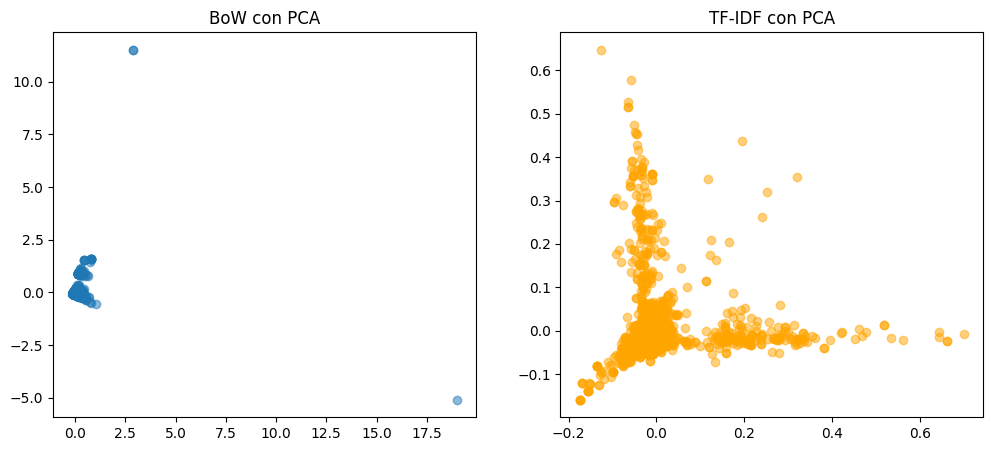

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducir a 2D con PCA
pca_bow = PCA(n_components=2).fit_transform(X_bow.toarray())
pca_tfidf = PCA(n_components=2).fit_transform(X_tfidf.toarray())

# Visualizar
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(pca_bow[:,0], pca_bow[:,1], alpha=0.5)
plt.title("BoW con PCA")

plt.subplot(1,2,2)
plt.scatter(pca_tfidf[:,0], pca_tfidf[:,1], alpha=0.5, color="orange")
plt.title("TF-IDF con PCA")

plt.show()


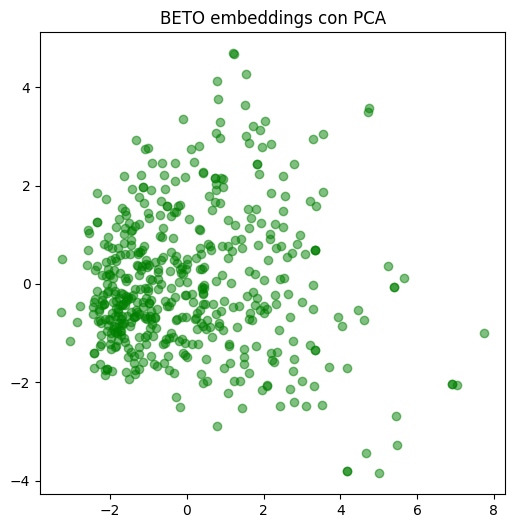

In [27]:
# Generar embeddings promedio de cada tweet
def get_sentence_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=50)
    outputs = model(**inputs)
    # vector promedio de todos los tokens
    return outputs.last_hidden_state.mean(dim=1).detach().numpy().flatten()

# Calcular embeddings para un subconjunto de tweets (ej: 500 para que no tarde mucho)
subset = df["clean_text"].astype(str).sample(500, random_state=42).tolist()
embeddings = np.array([get_sentence_embedding(t) for t in subset])

# Reducir a 2D con PCA
pca_beto = PCA(n_components=2).fit_transform(embeddings)

# Visualizar
plt.figure(figsize=(6,6))
plt.scatter(pca_beto[:,0], pca_beto[:,1], alpha=0.5, color="green")
plt.title("BETO embeddings con PCA")
plt.show()


# 🧮 3. Modelos Probabilísticos


In [ ]:
# Code here

# 🤖 4. Modelo avanzado

In [ ]:
# Code here